In [1]:
from scipy.fft import fft, ifft, fftshift, fft2, ifft2
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pywt
from scipy.io.wavfile import read as wave_read
%matplotlib inline 

In [2]:
# We need a tool that converts images into grayscale (i.e. all pixel values in [0, 1])
def gray_scale_convert(image):
    rescaled_image = np.zeros((image.shape[0], image.shape[1]))
    rescaled_image[:, :] = image
    rescaled_image -= np.min(rescaled_image)
    rescaled_image /= np.max(rescaled_image)
    return rescaled_image

# Noisy Signals

Just to get a sense of the power of the FFT, we look at the signal 

$$
s(t) = \cos(2t) + \sin(3t) + \epsilon(t),  \epsilon(t) \sim \mathcal{N}(0, 1).
$$

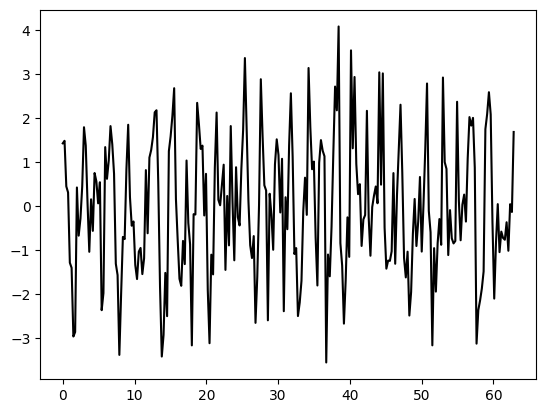

In [3]:
Npts = int(2**8)
times = np.linspace(0., 20.*np.pi, Npts)
rvals = np.random.randn(Npts)
sfun = lambda t: np.cos(2.*t) + np.sin(3.*t)
svals = sfun(times) + rvals

plt.plot(times, svals, 'k')
#plt.plot(times, sfun(times), 'r--')

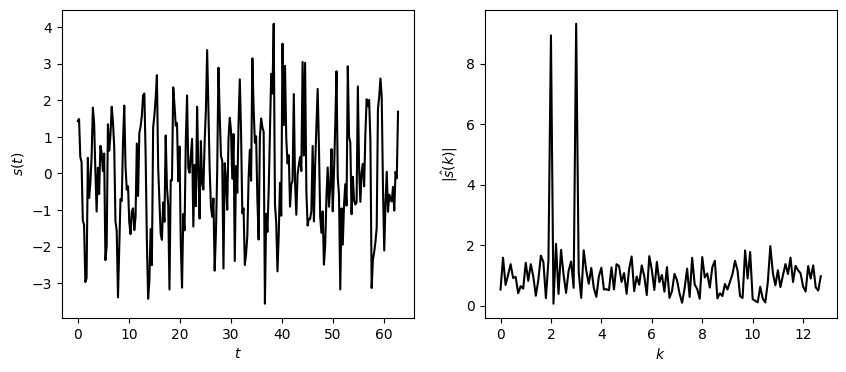

In [4]:
sfreq = fft(svals)
sfreq_plot = np.abs(fftshift(sfreq[:]))/np.sqrt(Npts)
kvals = np.arange(0, int(Npts/2)) * (2.*np.pi)/(20.*np.pi)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, svals, 'k')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfreq_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");


So now, if we want to denoise, we use the same kind of threshholding to maximum arguments we used for the SVD.  This looks like:

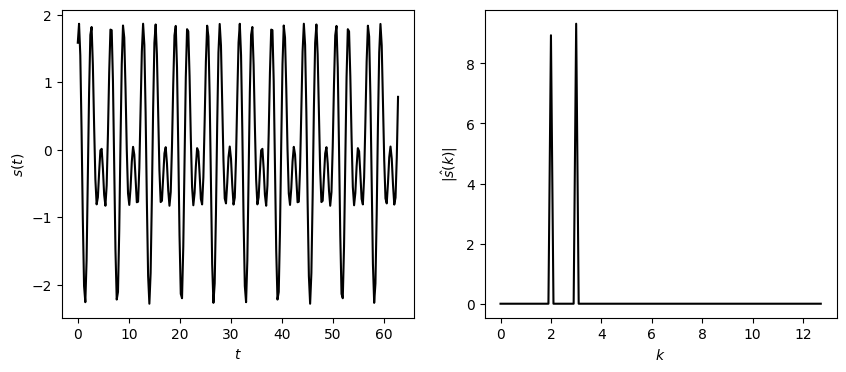

In [5]:
sfmax = np.max(np.abs(sfreq))
indskp = np.ma.log2(np.abs(sfreq)/sfmax) >= -1
sfilter = np.zeros(sfreq.size, dtype=np.complex128)
sfilter[indskp] = sfreq[indskp]
sfilter_plot = fftshift(np.abs(sfilter))/np.sqrt(Npts)
sdenoised = np.real(ifft(sfilter))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, sdenoised, 'k')
#ax[0].plot(times, sfun(times), 'r--')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfilter_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");

## FFT Theory

For $f(t+T)=f(t)$ with $f(t) \in L_{2}([0, T])$, again, we define the Fourier coefficient $\hat{f}_{n}$ for $n\in \mathbb{Z}$ as 

$$
\hat{f}_{n} = \left<f,\hat{e}_{n}\right> = \frac{1}{\sqrt{T}}\int_{0}^{T}f(t) e^{-2\pi i n t/T} dt.  
$$

With a modicum of theory, we can in turn write

$$
f(t) = \sum_{n=-\infty}^{\infty}\hat{f}_{n}\hat{e}_{n}(t), ~\hat{e}_{n}(t) = \frac{1}{\sqrt{T}}e^{-2\pi i n t/T}.
$$

We can think of the transition from $f(t)$ to the infinte vector $\left(\hat{f}_{n}\right)_{n=-\infty}^{\infty}$ as the _forward_ transform, and the process of summing the terms $\hat{f}_{n}\hat{e}_{n}(t)$ as the _inverse_ transform.  

Now, as we've examined in lecture and the homework, a central issue for Fourier transforms is the rate of decay of $\hat{f}_{n}$.  As we know, if we take 

$$
f(t) = \left\{\begin{array}{rl} 0 & 0 \leq t \leq \pi \\ 1 & \pi < t < 2\pi \end{array}\right.
$$

then 

$$
\hat{f}_{n} = \left\{\begin{array}{rl} \frac{i}{n}\sqrt{\frac{2}{\pi}} & n ~\text{odd} \\ 0 & n ~\text{even}\end{array}\right.
$$

So that slow rate of decay combined with the limited number of modes of the FFT makes for a tricky situation.  To see what I mean, let's compute.  

In [6]:
def step_fun(t):
    if 0 <= t and t <= np.pi:
        return 0
    else:
        return 1
    
def interp_freq(t, freq):
    Npts = freq.size
    hlf = int(Npts/2)
    tpi = 2.*np.pi
    nvals = np.append(np.arange(0, hlf+1), np.arange(-hlf+1, 0))
    phase = np.exp(nvals * 1j * t)
    return np.real(np.sum(freq * phase))/Npts

In [7]:
Npts = int(2**9)
tvals = np.linspace(0., 2.*np.pi, Npts)
fvals = [step_fun(tval) for tval in tvals]
ffreq = fft(fvals)
ffreq_plot = fftshift(np.abs(ffreq))

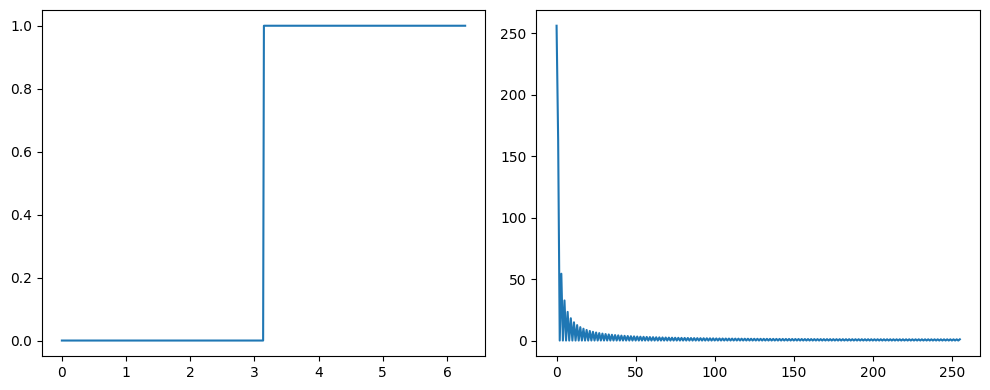

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].plot(tvals, fvals)
ax[1].plot(ffreq_plot[int(Npts/2):])

plt.tight_layout()

In [9]:
tvalsfine = np.linspace(0, 2.*np.pi, 2*Npts)
interp_step = [interp_freq(tval, ffreq) for tval in tvalsfine]

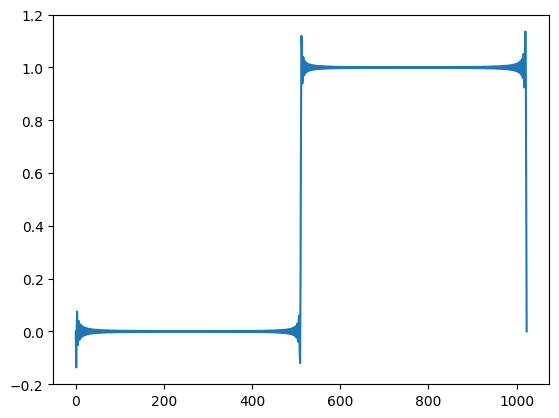

In [10]:
plt.plot(interp_step)

## The Fourier Transform

For $T$-periodic $f(t)$, if we let $T\rightarrow \infty$, we are lead to the trasnforms

$$
\hat{f}(\omega) = \int_{-\infty}^{\infty}e^{-i\omega t}f(t) dt, ~ f(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} e^{i\omega t}\hat{f}(\omega) d\omega
$$

With these tranforms, we can now study signals which do not necessarily repeat or have any particular structure at all.  To wit, we now look at the square pulse 
$$
I_{a}(t) = \frac{1}{a} I\left(\frac{t}{a}\right)
$$ 
where $a>0$ and where  

$$
I(t) = \left \{ 
\begin{array}{rl}
1 & -\frac{1}{2}\leq t \leq\frac{1}{2}\\
\\
0 & |t| > \frac{1}{2}
\end{array}
\right.
$$

We can readily see that 

$$
\hat{I}_{a}(\omega) = \frac{2}{\omega a}\sin\left(\frac{a\omega}{2}\right) = \text{sinc}\left(\frac{a\omega}{2}\right)
$$

So let's plot and see what happens.  

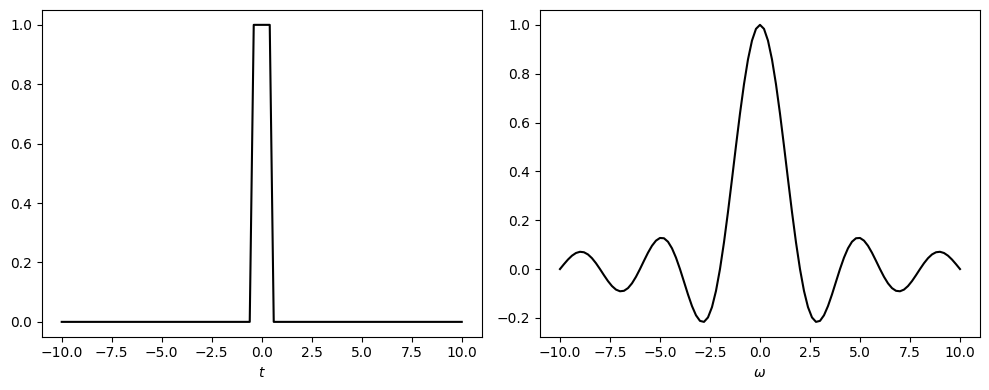

In [11]:
def sym_step(t):
    if np.abs(t) <= .5:
        return 1.
    else:
        return 0.

scale_step = lambda t, a: sym_step(t/a)/a

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

Npts = 101
tvals = np.linspace(-10., 10., Npts)
ovals = np.linspace(-10., 10., Npts)

aval = 1.

scale_eval = np.array([ scale_step(tval, aval) for tval in tvals ])

ax[0].plot(tvals, scale_eval, c='k')
ax[0].set_xlabel(r"$t$")
ax[1].plot(ovals, np.sinc( ovals * aval/2. ), c='k')
ax[1].set_xlabel(r"$\omega$")

plt.tight_layout()

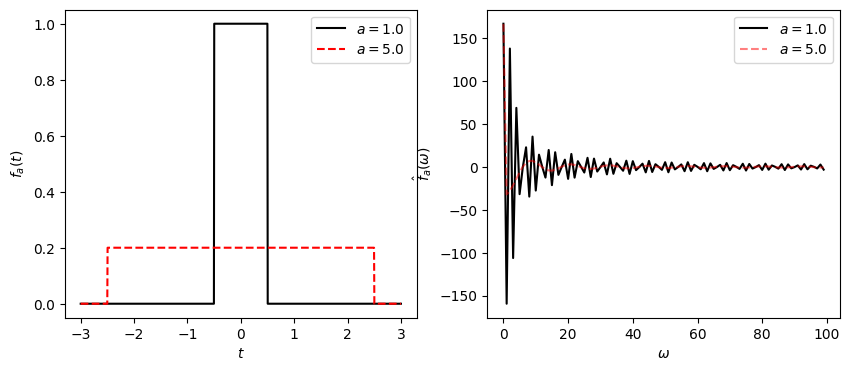

In [12]:
Npts = int(1e3)
tw = 3.
tvals = np.linspace(-tw, tw, Npts + 1)

aval1 = 1.
aval2 = 5.
stepvals1 = np.array([scale_step(tval, aval1) for tval in tvals])
stepvals2 = np.array([scale_step(tval, aval2) for tval in tvals])
fft1 = np.real(fft(stepvals1))
fft2 = np.real(fft(stepvals2))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, stepvals1, label=f"$a={aval1}$", color='k')
ax[0].plot(tvals, stepvals2, label=f"$a={aval2}$", color='r', ls='--')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f_{a}(t)$")
ax[0].legend()

ax[1].plot(fft1[:int(Npts/10)], label=f"$a={aval1}$", color='k')
ax[1].plot(fft2[:int(Npts/10)], label=f"$a={aval2}$", color='r', ls='--', alpha=.5)
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$\hat{f}_{a}(\omega)$")
ax[1].legend()

So what's the problem here?  Well first off, because we have a discontinuous signal, we get a very slowly decaying spectral representation of said signal, so we get no compression via frequency space.  We see this problem exacerbated by comparing the $a=1$ and $a=5$ cases.  But what we also lose is the fact that our signal only is even "on" for a relatively short amout of time.  So, given that via Fourier methods there is no way to get around the lack of compression in frequency space for sharp signals, can we at least come up with a method that still identifies when signals turn off, on, or change in significant ways and that gives us frequency characterizations which change in time?  

## Short-Time-Fourier Transforms

So what we have seen is that as we want to represent sharper features in time (or space in the context of images), if we want to stick with strict Fourier methods, we run into a wall in which sharper features demand ever more information from frequency space, making any kind of "sparse" or low-memory representation impossible.  

A path out of this conudrum is to start to expand on our Fourier transform in clever ways that allow us to better represent sharp or more intricate features.  One way to do this is through the so called _Gabor_ (or Short-Time-Fourier) transform, defined for $f(t)$ as 

$$
\mathcal{G}(t,\omega)\{f\} = \int_{-\infty}^{\infty}f(\tau)g_{W}(\tau - t)e^{-i\omega \tau} d\tau.  
$$

Here, $g_{W}(s)\geq 0$ and is chosen to have finite support or to decay so quickly it effectively does.  A simple choice is to let 

$$
g_{W}(s) = I(s/b), b > 0.
$$

In this case, we find that $\mathcal{G}(t,\omega)\{I_{a}\}$ is 

$$
\mathcal{G}(t,\omega)\{I_{a}\} = \frac{1}{a}\int_{-a/2}^{a/2}I\left(\frac{\tau - t}{b}\right)e^{-i\omega \tau}.
$$

We of course have $I\left(\frac{\tau - t}{b}\right) = 1$ for $t-b/2\leq \tau \leq t+b/2$, so the degree to which the intervals $[-a/2,a/2]$ and $[t-b/2,t+b/2]$ overlap is the extent to which the integral returns anything at all.  

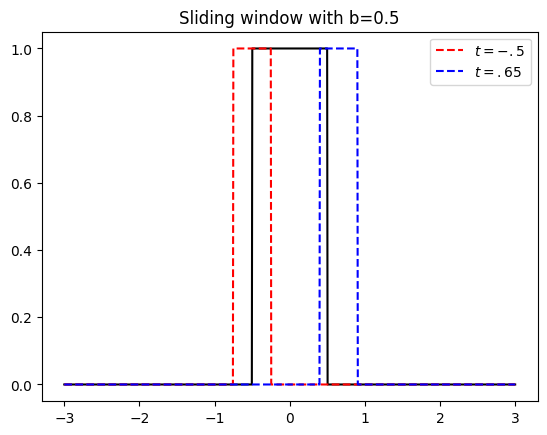

In [13]:
bval = .5

window1 = np.array([bval*scale_step(tval + .5, bval) for tval in tvals])
window2 = np.array([bval*scale_step(tval - .65, bval) for tval in tvals])

plt.plot(tvals, stepvals1, color='k')
plt.plot(tvals, window1, c='r', ls='--', label=r"$t=-.5$")
plt.plot(tvals, window2, c='b', ls='--', label=r"$t=.65$")
plt.title(f"Sliding window with b={bval}")
plt.legend()

In [14]:
def stft_window(a, b, t, omega):
    if (t-b/2. > a/2.) or (t+b/2. < -a/2.):
        return 0.
    else:
        lhs = np.max([-a/2., t-b/2.])
        rhs = np.min([a/2., t+b/2.])
        integral = lambda t: np.exp(-1j*omega*t)/(-1j*omega*a)
        return np.abs( integral(rhs) - integral(lhs) )

Text(0.5, 1.0, 'Short Time Fourier Transform of Step with a=1.0 and b=0.5.')

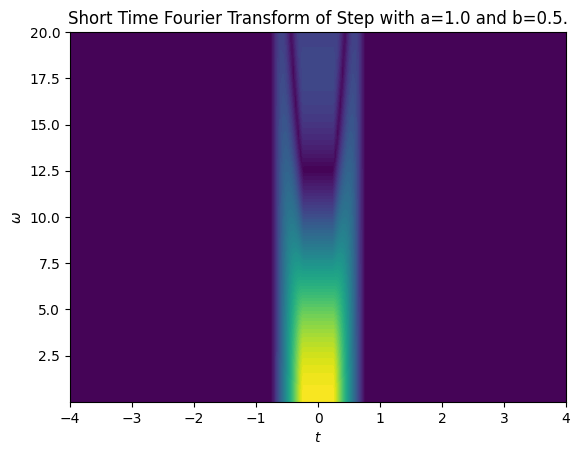

In [15]:
a = 1.
b = .5
Npts = int(2e2)
tvals = np.linspace(-4, 4, Npts+1)
ovals = np.linspace(1e-3, 20., Npts+1)
box_stft = np.zeros((Npts+1, Npts+1), dtype=np.float64)
for jj in range(Npts+1):
    for kk in range(Npts+1):
        box_stft[kk, jj] = stft_window(a, b, tvals[jj], ovals[kk])

plt.contourf(tvals, ovals, box_stft, levels=80)
plt.xlabel(r"$t$")
plt.ylabel(r"$\omega$")
plt.title(f"Short Time Fourier Transform of Step with a={a} and b={b}.")

Now let's look at what an STFS of our steps looks like and also try to see if we can't use the intuition from our analytic computations to help us build feel for how to work with the STFS.  

### A note on variables in the STFT

So, there are two variables, `nperseg` and `noverlap`, which can have a big impact on what the results of your STFT looks like.  `nperseg` determines how many segments you separate your original signal into.  Suppose you have 1000 points in your original signal, and you set `nperseg=100`.  Then you will create 10 separate samples, over each of which you take a windowed Fourier transform.  `noverlap` (which is always strictly less than `nperseg`) determines by how many points in time the segments overlap.  If they never overlap, you get jagged, essentially discontinuous results.  Overlapping too much, and you tend to smear out details.  And all of this needs to be balanced against the width of your window.  For example, there is no point in choosing `nperseg` so large it involves computing points well outside the width of your window.     

Throughout the remaining examples, we use the Gaussian windowing function so that $g_{W}(s;b) = e^{-s^2/b}$.

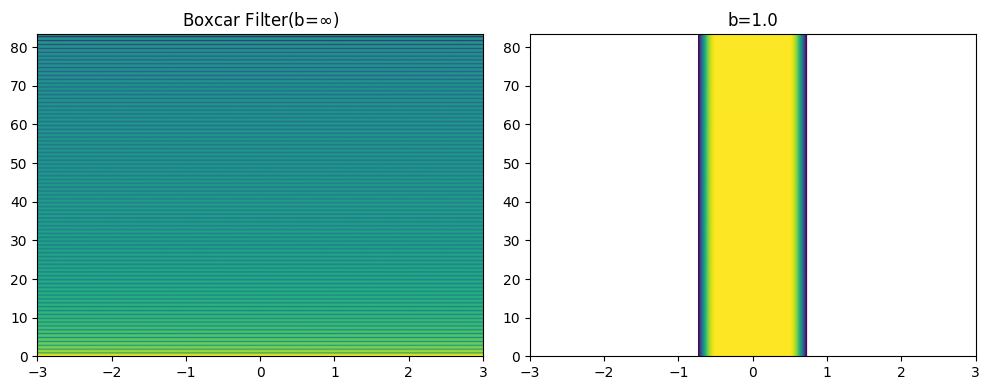

In [16]:
# Okay, this while we can deal with this analytically, dealing with it numerically is a little bit of a nightmare
# given how narrow our profiles are.  That said, if you choose seglength and noverlap to be very large, you can 
# make this do what you think it should.  

Npts = int(1e3)
tw = 3.
tvals = np.linspace(-tw, tw, Npts + 1)

aval1 = 1.
aval2 = 5.
stepvals1 = np.array([scale_step(tval, aval1) for tval in tvals])

bval = 1.
fs = Npts/(2*tw)

f1, t1, Zxx1 = stft(stepvals1, fs=fs, window = ('boxcar'), nperseg=Npts, noverlap=Npts-1, boundary='even')
f2, t2, Zxx2 = stft(stepvals1, fs=fs, window = ('gaussian', bval), nperseg=Npts, noverlap=Npts-1, boundary='even')

scfac1 = np.max(np.abs(Zxx1))
scfac2 = np.max(np.abs(Zxx2))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].pcolormesh(t1-tw, f1, np.ma.log10(np.abs(Zxx1)/scfac1), shading='gouraud')
ax[0].set_title(r"Boxcar Filter(b=$\infty$)")
ax[1].pcolormesh(t2-tw, f2, np.ma.log10(np.abs(Zxx2)/scfac2), shading='gouraud')
ax[1].set_title(f"b={bval}")
plt.tight_layout()

### Frequency Modulation through a Chirp

So okay, cool, for a sharp feature, we now have a transform method which lets us track its behavior in both time and frequency.  This comes at a cost of losing some time resolution if we don't want to have an even more slowly decaying profile in frequency space.  

What else might we do with our short-time Fourier transform?  A really classic example is studying frequency-modulated signals.  For example, what can we say about the signal

$$
f(t) = \cos\left(2\pi f(t) t\right),  ~f(t) = \left(f_{0}  + (f_{1}-f_{0})\frac{t^{2}}{3t_{w}^{2}}\right)
$$

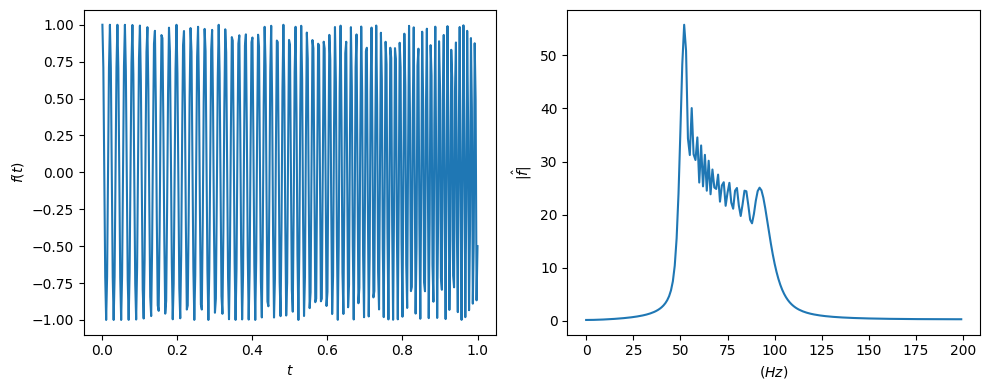

In [17]:
tpi = 2.*np.pi
chirp = lambda t, om0, om1: np.cos(tpi*t*(om0 + (om1-om0)*t**2./(3.*tw**2.)))
f0 = 50 # 50 Hz, 
f1 = 2.*f0 # 100 Hz
Npts = int(4*f1) # sample at twice the highest frequency 
tw = 1. # this is understood to be 1 second of time
tvals = np.linspace(0., tw, Npts + 1)
chirpvals = chirp(tvals, f0, f1)
fftchirp = np.abs(fft(chirpvals))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, chirpvals)
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f(t)$")
ax[1].plot(fftchirp[:int(fftchirp.size/2)])
ax[1].set_xlabel(r"$(Hz)$")
ax[1].set_ylabel(r"$|\hat{f}|$")
plt.tight_layout()


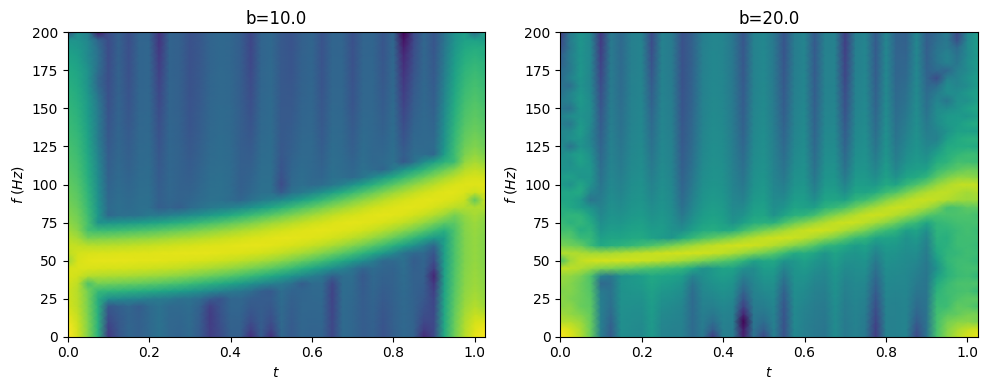

In [18]:
 # again, we have to be very thoughtful about how we choose seglength and noverlap

bval1 = 10.
bval2 = 20.
fs = Npts
seglength = int(.2*Npts)
f1, t1, Zxx1 = stft(chirpvals, fs=fs, window = ('gaussian', bval1), nperseg=seglength, noverlap=int(seglength-10), boundary='odd')
f2, t2, Zxx2 = stft(chirpvals, fs=fs, window = ('gaussian', bval2), nperseg=seglength, noverlap=int(seglength-10), boundary='odd')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].pcolormesh(t1, f1, np.ma.log10(np.abs(Zxx1)), shading='gouraud')
ax[0].set_title(f"b={bval1}")
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f ~(Hz)$")
ax[1].pcolormesh(t2, f2, np.ma.log10(np.abs(Zxx2)), shading='gouraud')
ax[1].set_title(f"b={bval2}")
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$f ~(Hz)$")
plt.tight_layout()

### STFS on Star Wars

In [19]:
rate, star_wars_data = wave_read('StarWars60.wav') # This is the first minute of the 
print(type(star_wars_data))

<class 'numpy.ndarray'>


In [20]:
nsamp = star_wars_data.size
star_wars_fs = nsamp/60. # number of samples taken over 60s is sampling frequency
tvals = np.linspace(0., 60., nsamp)
freqvals = np.arange(int(nsamp/2))/60.
print(f"File is sampled at {star_wars_fs} cycles/second")
freq_star = np.abs(fft(star_wars_data))

File is sampled at 22050.0 cycles/second


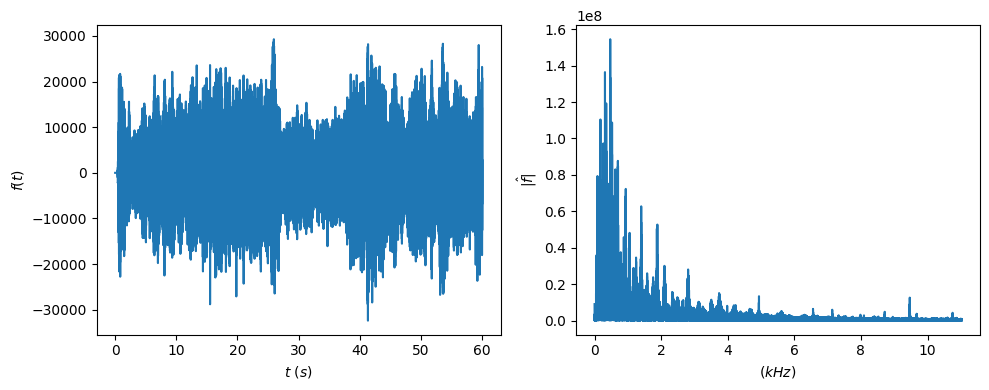

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, star_wars_data)
ax[0].set_xlabel(r"$t ~(s)$")
ax[0].set_ylabel(r"$f(t)$")
ax[1].plot(freqvals/1000, freq_star[:int(nsamp/2)])
ax[1].set_xlabel(r"$(kHz)$")
ax[1].set_ylabel(r"$|\hat{f}|$")
plt.tight_layout()

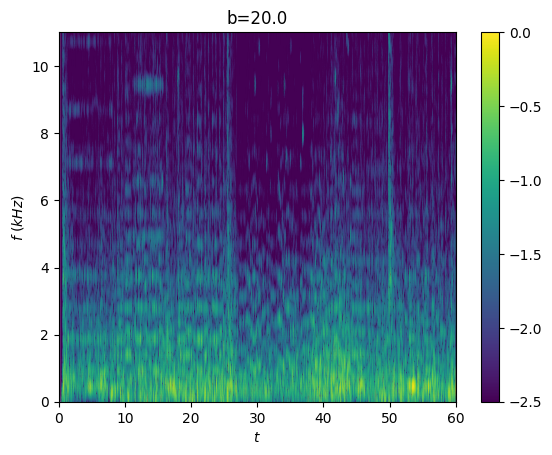

In [22]:
bval2 = 20.
seglength = int(nsamp/1000)
f2, t2, Zxx2 = stft(star_wars_data, fs=star_wars_fs, window = ('gaussian', bval2), noverlap=int(seglength/10), nperseg=seglength)
scalefac = np.max(np.abs(Zxx2))
plt.pcolormesh(t2, f2/1000, np.ma.log10(np.abs(Zxx2)/scalefac), vmin=-2.5, vmax = 0, shading='gouraud')
plt.colorbar()
plt.title(f"b={bval2}")
plt.xlabel(r"$t$")
plt.ylabel(r"$f ~(kHz)$");

## Wavelets

In [23]:
# Perform a wavelet decomposition on the chirp signal

tpi = 2.*np.pi
chirp = lambda t, om0, om1: np.cos(tpi*t*(om0 + (om1-om0)*t**2./(3.*tw**2.)))
f0 = 50 # 50 Hz, 
f1 = 2.*f0 # 100 Hz
#Npts = int(4*f1) # sample at twice the highest frequency
Npts = 2**8 
tw = 1. # this is understood to be 1 second of time
tvals = np.linspace(0., tw, Npts + 1)
chirpvals = chirp(tvals, f0, f1)

levels = 2
wave_fun = 'coif4'
coeffs = pywt.wavedec(chirpvals, wave_fun, level=levels)
print(len(coeffs))


3


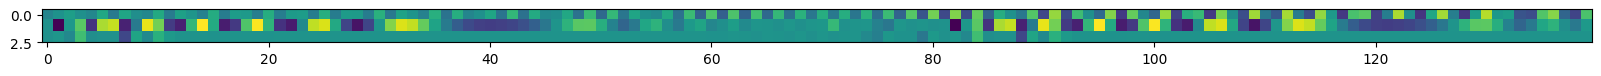

In [24]:
# Plot the multi-resolution analysis represented by the coefficients
fig = plt.figure(figsize=(20,24))
siglength = coeffs[-1].size
coeffsmat = np.zeros((levels+1, siglength))
coeffsmat[0, :] = coeffs[levels]
for jj in range(1, levels):
    if jj < levels-1:
        coeffsmat[jj, :] = np.tile(coeffs[levels-jj], 2**jj)[:siglength]
    else:
        coeffsmat[jj, :] = np.tile(coeffs[levels-jj], 2**jj)[:siglength]
        coeffsmat[jj+1, :] = np.tile(coeffs[levels-jj-1], 2**jj)[:siglength]

plt.imshow(coeffsmat)

In [25]:
detail_recon = [None]*(levels+1)
chirp_details = [None]*(levels+1)
for ll in range(levels+1):
    for jj in range(levels+1):
        if jj == ll:
            detail_recon[ll] = np.array([v for v in coeffs[ll]]) # zero out everything but the approximation coefficients.
        else:
            detail_recon[jj] = np.array([np.zeros_like(v) for v in coeffs[jj]]) # zero out everything but the approximation coefficients.  
    chirp_details[ll] = pywt.waverec(detail_recon, wave_fun)

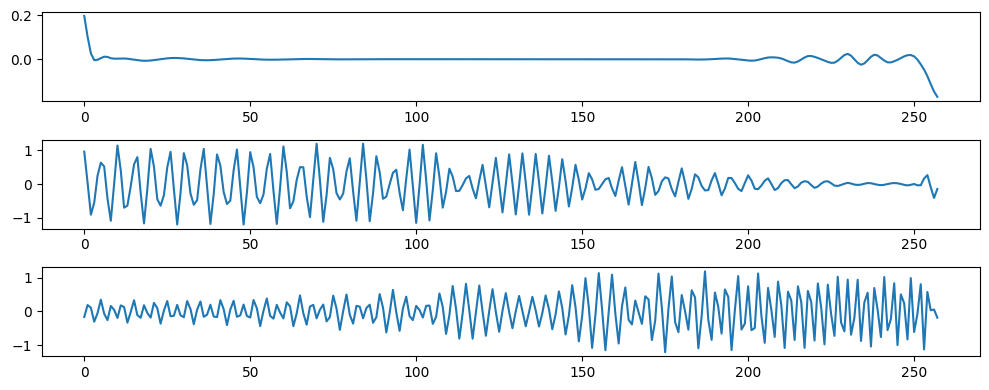

In [26]:
fig, axes = plt.subplots(levels+1, 1, figsize=(10, 4))
ax = axes.ravel()
for jj in range(levels+1):
    ax[jj].plot(chirp_details[jj])
plt.tight_layout()

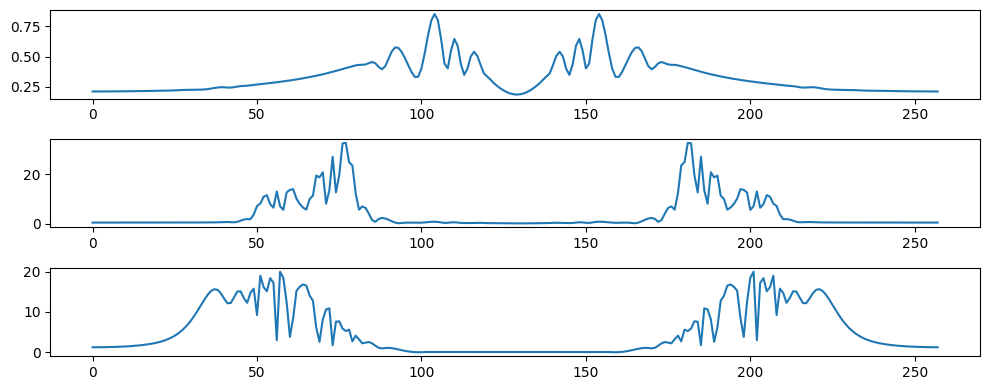

In [27]:
fig, axes = plt.subplots(levels+1, 1, figsize=(10, 4))
ax = axes.ravel()
for jj in range(levels+1):
    chirp_freq = (np.abs( np.fft.fftshift(np.fft.fft(chirp_details[jj])) ))
    ax[jj].plot(chirp_freq)
plt.tight_layout()

# Image Analysis

Now, what happens when we use the 2D FFT on Beans?  

In [ ]:
# Find, load, and convert image from textbook data
# Image is in Lecture_Notes folder 
beans = io.imread('beans.jpg', as_gray=True)
beans_freq = np.fft.fft2(beans)
beans_freq_plot = np.log10(fftshift(np.abs(beans_freq)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(beans, cmap=plt.cm.gray)
ax[1].matshow(beans_freq_plot)

plt.tight_layout()

TypeError: 'numpy.ndarray' object is not callable

So, there isn't really any clear interpretation of Beans in the FFT plot to the right.  Nevertheless, we can still do useful things with it.  To wit, we can look at, as you might have guessed, amplitude comparisons and only keep large Fourier coefficients.  

In [ ]:
max_freq = np.max(np.abs(beans_freq))
indskp = np.ma.log10(np.abs(beans_freq)/max_freq) >= -3
dog_filter = np.zeros((beans_freq.shape[0], beans_freq.shape[1]), dtype=np.complex128)
dog_filter[indskp] = beans_freq[indskp]
beans_reduced = gray_scale_convert(np.real(ifft2(dog_filter)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(beans, cmap=plt.cm.gray)
ax[0].set_title("Original Beans")
ax[1].imshow(beans_reduced, cmap=plt.cm.gray)
ax[1].set_title("Filtered Beans")
plt.tight_layout()

So with almost none of the affiliated Fourier spectra, we get a weirdly good recreation of Beans, but in a very different way than what we did with the SVD.  Let's see how the original and altered images look though through that lense.  

In [ ]:
u, s, vh = np.linalg.svd(beans)
ur, sr, vhr = np.linalg.svd(beans_reduced)

plt.plot(np.ma.log10(s/s[0]), color='k')
plt.plot(np.ma.log10(sr/sr[0]), color='r', ls='--')

So we see our FFT based approach is similar to chopping off dimensions in the SVD, though perhaps not quite as systematic in how we can describe the effect. 

In [29]:
levels = 4
print(beans.shape)
coeffs = pywt.wavedec2(beans, 'db1', level=levels) # coeffs = (cA, (cH1, cV1, cD1), (cH2, cV2, cD2), etc...)

(1600, 1200)


In [30]:
nrows, ncols = coeffs[0].shape
print(coeffs[0].shape)

trows = nrows*int(2**levels)
tcols = ncols*int(2**levels)

coeffmat = np.zeros((trows, tcols))

for jj in range(levels+1):
    if jj == 0:
        coeffmat[:nrows , :ncols] = gray_scale_convert(coeffs[jj])
    else:
        sclfac = int(2**(jj-1))
        for ll in range(3):
            coeffmat[:sclfac*nrows, sclfac*ncols:2*sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])
            coeffmat[sclfac*nrows:2*sclfac*nrows, :sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])
            coeffmat[sclfac*nrows:2*sclfac*nrows, sclfac*ncols:2*sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])

(100, 75)


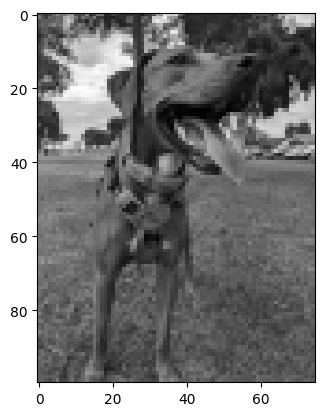

In [32]:
plt.imshow(coeffs[0], interpolation='nearest', cmap=plt.cm.grey)

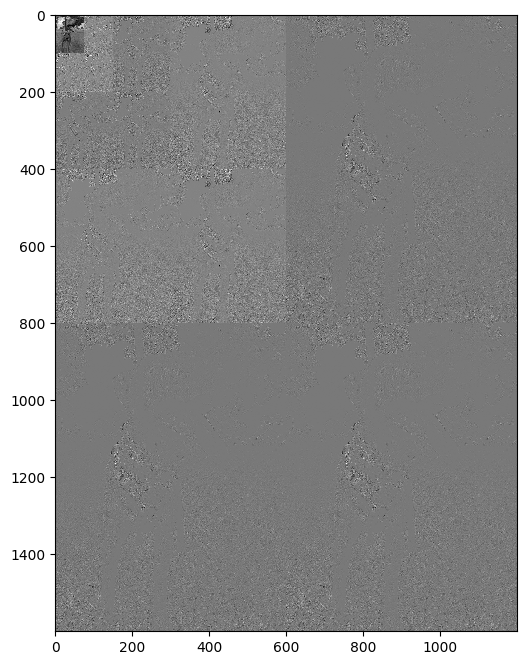

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.imshow(coeffmat, interpolation='nearest', cmap=plt.cm.grey)

In [34]:
recon = [None]*(levels+1)
recon[0] = coeffs[0]
for ll in range(levels):
    recon[ll+1] = tuple([np.zeros_like(v) for v in coeffs[ll+1]]) # zero out everything but the approximation coefficients.  
beans_approx = pywt.waverec2(tuple(recon), 'db1')

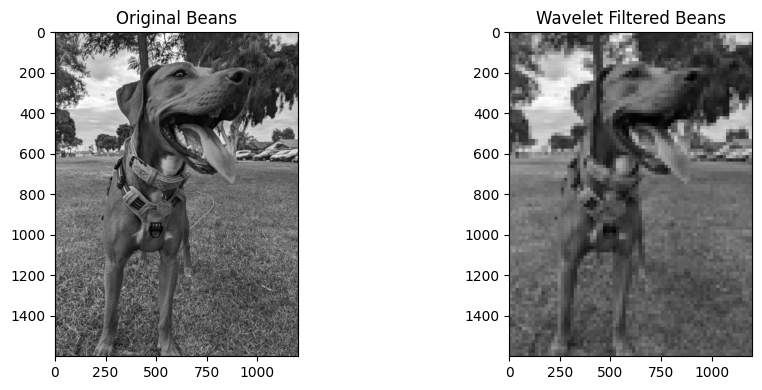

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].imshow(beans, cmap=plt.cm.grey)
ax[0].set_title("Original Beans")
ax[1].imshow(gray_scale_convert(beans_approx), cmap=plt.cm.grey)
ax[1].set_title("Wavelet Filtered Beans")
plt.tight_layout()

In [36]:
detail_recon = [None]*(levels+1)
beans_details = [None]*(levels)
for ll in range(levels):
    for jj in range(levels+1):
        if jj != ll:
            detail_recon[jj] = tuple([np.zeros_like(v) for v in coeffs[jj]]) # zero out everything but the approximation coefficients.  
        else:
            detail_recon[ll] = tuple([v for v in coeffs[ll]]) # zero out everything but the approximation coefficients.
    beans_details[ll] = pywt.waverec2(tuple(detail_recon), 'db1')

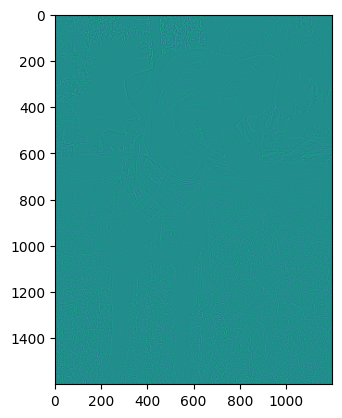

In [40]:
plt.imshow(gray_scale_convert(beans_details[3]))

# Get brightness range - i.e. darkest and lightest pixels
min=np.min(gray_scale_convert(beans_details[0]))        # result=144
max=np.max(gray_scale_convert(beans_details[0]))        # result=216


